In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

seed = 0

np.random.seed(seed)

In [2]:
def read_mca(filepath):
    filepath = Path(filepath)
    
    lines = filepath.read_text(encoding='latin-1').splitlines()
    
    data_start = None
    data_end = None
    for i, line in enumerate(lines):
        if line.strip() == "<<DATA>>":
            data_start = i + 1
        elif line.strip() == "<<END>>":
            data_end = i
    
    count_lines = lines[data_start:data_end]
    counts = [int(x.strip()) for x in count_lines if x.strip() and x.strip().isdigit()]
    
    counts = np.array(counts, dtype=np.int64)
    
    df = pd.DataFrame({
        'channel': np.arange(len(counts)),
        'counts': counts
    })
    
    calib = {'a': 0.0, 'b': 0.0}  # linear: E = a + b * channel
    for line in lines:
        if 'keV' in line and len(line.split()) == 3:
            line1 = lines[lines.index(line)+1]
            ch1, e1 = float(line1.split()[0]), float(line1.split()[1])
            line2 = lines[lines.index(line)+2]
            ch2, e2 = float(line2.split()[0]), float(line2.split()[1])
            
            calib['b'] = (e2 - e1) / (ch2 - ch1)   # slope in keV/channel
            calib['a'] = e1 - calib['b'] * ch1     # offset
            break
    
    df['energy_keV'] = calib['a'] + calib['b'] * df['channel']
    
    metadata = {}
    for line in lines:
        if 'LIVE_TIME' in line:
            metadata['live_time'] = float(line.split('-')[-1].strip())
        elif 'REAL_TIME' in line:
            metadata['real_time'] = float(line.split('-')[-1].strip())
        elif 'START_TIME' in line:
            metadata['start_time'] = line.split('-', 1)[-1].strip()
    
    df.attrs['metadata'] = metadata
    df.attrs['calibration'] = calib
    
    return df

### Обработаем `data.txt`

In [3]:
concentrations = pd.read_csv("data/data.txt", delimiter=' ', names=["concentration", "spectrum_name"], index_col="spectrum_name")

concentrations.head(3)

,concentration
spectrum_name,
8957,11.01
9292,12.40
9262,12.45


In [4]:
concentrations.rename(index={'2500_03112023_Spec5601': '5601'}, inplace=True)

In [5]:
duplicates = concentrations.index.duplicated()
print(concentrations[duplicates])

               concentration
spectrum_name               
13512                  25.61


In [6]:
concentrations = concentrations[~duplicates]
concentrations.shape

(243, 1)

### Обработаем `Elements.txt`

In [7]:
elements = pd.read_csv("data/Elements.txt", delimiter=' ', names=["peak_name", "peak_start", "peak_end"], 
                       dtype={"peak_start": int, "end": int})
elements.sort_values(by="peak_start", inplace=True)

### Обработаем файлы спектров

In [8]:
import os

dir_name = "data/spectra"
train_spectra_dict = {}
for file_name in concentrations.index:
    file_path = os.path.join(dir_name, file_name + ".mca")

    if file_name == "5601":
        train_spectra_dict[file_name] = read_mca(os.path.join(dir_name, "2500_03112023_Spec5601.mca"))
        continue
    
    train_spectra_dict[file_name] = read_mca(file_path)

In [9]:
print(train_spectra_dict["8001"].attrs["metadata"])
print()
print("max spectrum name:", max(list(map(int, train_spectra_dict.keys()))))
print("min spectrum name:", min(list(map(int, train_spectra_dict.keys()))))

train_spectra_dict["8001"]

{'live_time': 48.696, 'real_time': 59.772, 'start_time': '08/16/2024 08:46:26'}

max spectrum name: 13753
min spectrum name: 5601


,channel,counts,energy_keV
0,0,0,0.018782
1,1,0,0.045949
2,2,0,0.073116
3,3,0,0.100283
4,4,0,0.127450
...,...,...,...
1019,1019,277,27.702096
1020,1020,279,27.729263
1021,1021,267,27.756431
1022,1022,247,27.783598


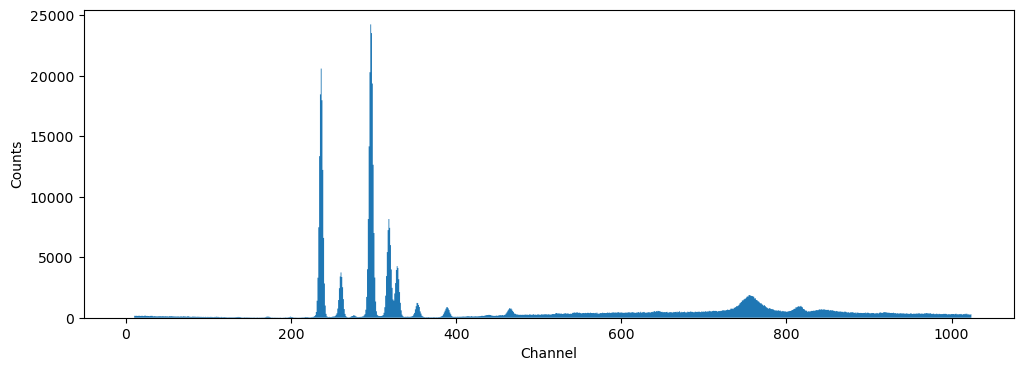

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (12, 4))

plt.stairs(train_spectra_dict["8001"]['counts'], edges=np.arange(train_spectra_dict["8001"].shape[0] + 1), fill=True)
# plt.plot(spectra_dict["8001"]["counts"])
plt.xlabel('Channel')
plt.ylabel('Counts')
plt.show()

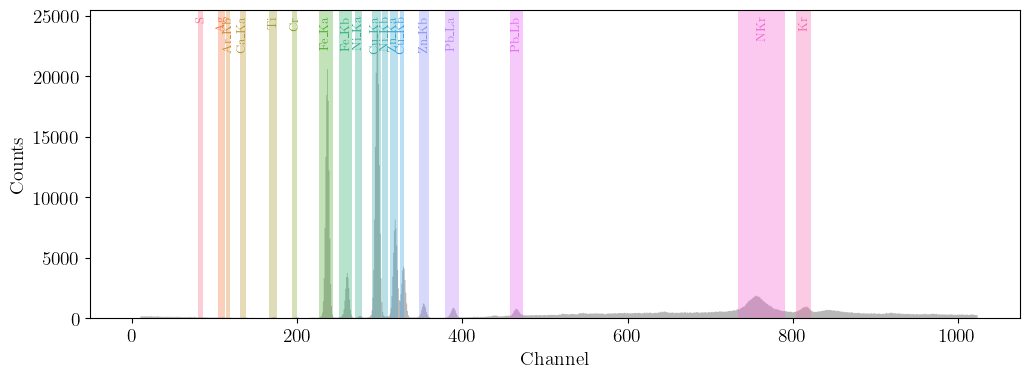

In [11]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 14,
    "text.latex.preamble": r"\usepackage{amsmath,amssymb}",
})

# elements: columns = [peak_name, peak_start, peak_end]
# spectra_dict["8001"]["counts"] is a 1D array/Series-like

counts = train_spectra_dict["8001"]["counts"].to_numpy()  # if it's already a numpy array, keep it as-is
edges = np.arange(counts.shape[0] + 1)

fig, ax = plt.subplots(figsize=(12, 4))

# Base spectrum
ax.stairs(counts, edges=edges, fill=True, alpha=0.35, color="0.2")  # keep base subtle

# One distinct color per peak
palette = sns.color_palette("husl", n_colors=len(elements))  # evenly spaced hues [web:13]

for (i, row) in enumerate(elements.itertuples(index=False)):
    c = palette[i]
    ax.axvspan(row.peak_start, row.peak_end, color=c, alpha=0.35, lw=0)  # shaded region [web:1]
    ax.text((row.peak_start + row.peak_end) / 2, ax.get_ylim()[1] * 0.98,
            row.peak_name, ha="center", va="top", fontsize=9, color=c, rotation=90)

ax.set_xlabel("Channel")
ax.set_ylabel("Counts")
plt.savefig('spectrum_example.png', bbox_inches="tight", dpi=500)
plt.show()


In [12]:
for i in range(1, elements.shape[0]):
    print(elements.iloc[i].peak_start - elements.iloc[i-1].peak_end)

18
2
11
28
19
26
8
4
12
2
2
2
18
20
61
261
13


### Создадим из спектров фичи на основе данных о пиках из `Elements.txt`

In [13]:
elements.info

<bound method DataFrame.info of    peak_name  peak_start  peak_end
0          S          80        86
1         Ag         104       112
5      Ar_Kb         114       119
6      Ca_Ka         130       138
15        Ti         166       175
2         Cr         194       200
3      Fe_Ka         226       243
4      Fe_Kb         251       266
7      Ni_Ka         270       278
9      Cu_Ka         290       301
8      Ni_Kb         303       310
11     Zn_Ka         312       322
10     Cu_Kb         324       329
12     Zn_Kb         347       359
13     Pb_La         379       396
14     Pb_Lb         457       473
16       NKr         734       791
17        Kr         804       822>

In [14]:
import numpy as np
import pandas as pd

def net_peak_area_neighbor_aware(counts, L, R, prev_end=None, next_start=None,
                                guard_default=2, bkg_width_default=6,
                                min_bkg_width=2):
    n = len(counts)
    L = int(L); R = int(R)
    if R <= L:
        return np.nan

    peak_counts = counts[L:R].sum()
    peak_len = R - L

    left_space = (L - prev_end) if prev_end is not None else L
    right_space = (next_start - R) if next_start is not None else (n - R)

    guard = min(guard_default, max(0, left_space - min_bkg_width), max(0, right_space - min_bkg_width))
    bkg_width = min(bkg_width_default, left_space - guard, right_space - guard)

    if bkg_width < min_bkg_width:
        return np.nan

    left_end = L - guard
    left_start = left_end - bkg_width
    right_start = R + guard
    right_end = right_start + bkg_width

    left_start = max(0, left_start); left_end = max(0, left_end)
    right_start = min(n, right_start); right_end = min(n, right_end)

    if left_end - left_start < min_bkg_width or right_end - right_start < min_bkg_width:
        return np.nan

    left_mean = counts[left_start:left_end].mean()
    right_mean = counts[right_start:right_end].mean()

    bkg_under_peak = 0.5 * (left_mean + right_mean) * peak_len
    net = peak_counts - bkg_under_peak
    return max(net, 0.0)

def process_spectra_intensities(spectra_dict, elements_sorted, live_time_source):
    intensities_data = {}
    total_live_time = 0.0
    
    for name, data in spectra_dict.items():
        counts = np.asarray(data["counts"])
        
        if isinstance(live_time_source, (int, float)):
            current_live_time = live_time_source
        else:
            current_live_time = float(data.attrs["metadata"]["live_time"])
            total_live_time += current_live_time

        row = {}
        for i, element in elements_sorted.iterrows():
            L = element["peak_start"]
            R = element["peak_end"]

            prev_end = elements_sorted.iloc[i-1]["peak_end"] if i > 0 else None
            next_start = elements_sorted.iloc[i+1]["peak_start"] if i < len(elements_sorted)-1 else None

            net_counts = net_peak_area_neighbor_aware(
                counts, L, R,
                prev_end=prev_end, next_start=next_start,
                guard_default=2, bkg_width_default=6, min_bkg_width=2
            )

            row["Intensity_" + element["peak_name"]] = net_counts / current_live_time

        intensities_data[name] = row

    df = pd.DataFrame.from_dict(intensities_data, orient="index")
    df.index.name = "spectrum_name"
    return df, total_live_time

elements_sorted = elements.sort_values(["peak_start", "peak_end"]).reset_index(drop=True)

intensities, glob_live_time = process_spectra_intensities(
    train_spectra_dict, elements_sorted, live_time_source="metadata"
)

In [15]:
intensities

,Intensity_S,Intensity_Ag,Intensity_Ar_Kb,Intensity_Ca_Ka,Intensity_Ti,Intensity_Cr,Intensity_Fe_Ka,Intensity_Fe_Kb,Intensity_Ni_Ka,Intensity_Cu_Ka,Intensity_Ni_Kb,Intensity_Zn_Ka,Intensity_Cu_Kb,Intensity_Zn_Kb,Intensity_Pb_La,Intensity_Pb_Lb,Intensity_NKr,Intensity_Kr
spectrum_name,,,,,,,,,,,,,,,,,,
8957,0.275845,1.930912,0.000000,2.065297,6.248939,3.299525,1839.698976,351.181888,13.771007,1671.108471,0.0,522.491937,0.000000,117.064166,80.376846,52.707520,1009.574987,117.849262
9292,0.116328,1.332487,0.560491,1.219684,5.700085,2.654399,1628.898759,320.230541,13.642132,1351.506980,0.0,377.051607,0.000000,87.330795,63.968204,39.629160,1028.648477,113.525804
9262,0.789989,2.591165,0.000000,1.474647,4.945333,3.128357,1601.576819,313.494070,13.124355,1469.854010,0.0,363.194927,5.687923,85.297773,54.649701,36.718701,998.783417,105.637363
8512,0.000000,2.318102,0.000000,1.900426,7.914961,2.850639,1994.524963,388.992148,10.191296,1884.878039,0.0,489.516331,12.927074,108.888146,82.045499,62.477376,862.527149,110.934759
8864,1.088232,0.917529,0.149365,1.650130,5.553185,2.923290,1675.562787,327.611224,13.442868,1522.116718,0.0,492.638430,0.000000,112.813400,78.638999,47.604822,1087.565347,124.709271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10717,0.319528,1.937785,0.376219,1.477389,4.561009,2.927292,1608.947137,312.137954,9.668309,3406.836876,0.0,296.099693,65.616690,66.564967,64.762896,42.012822,670.179760,90.787277
10460,0.766660,1.965795,0.078632,0.373501,2.162375,1.916650,707.291462,135.084529,11.087085,1762.654806,0.0,300.314527,24.041675,68.193434,40.018675,23.360199,719.825044,76.036957
11319,0.000000,2.027768,0.475905,1.303565,5.307372,2.876120,1529.926821,290.601916,7.159263,4003.005442,0.0,324.701525,83.790271,67.930228,65.733480,47.590474,638.084794,91.870306


In [16]:
intensities.isna().sum()

Intensity_S        0
Intensity_Ag       0
Intensity_Ar_Kb    0
Intensity_Ca_Ka    0
Intensity_Ti       0
Intensity_Cr       0
Intensity_Fe_Ka    0
Intensity_Fe_Kb    0
Intensity_Ni_Ka    0
Intensity_Cu_Ka    0
Intensity_Ni_Kb    0
Intensity_Zn_Ka    0
Intensity_Cu_Kb    0
Intensity_Zn_Kb    0
Intensity_Pb_La    0
Intensity_Pb_Lb    0
Intensity_NKr      0
Intensity_Kr       0
dtype: int64

### Train/Test split

In [17]:
small_threshold = concentrations['concentration'].quantile(0.35) 
large_threshold = concentrations['concentration'].quantile(0.7) 

concentrations['category'] = pd.cut(
    concentrations['concentration'],
    bins=[0, small_threshold, large_threshold, float('inf')],
    labels=['small', 'mid', 'large']
)

concentrations.sample(5)

,concentration,category
spectrum_name,,
8162,20.75,mid
8288,22.46,mid
9212,15.97,small
10364,18.95,small
8495,20.49,mid


In [18]:
intensities

,Intensity_S,Intensity_Ag,Intensity_Ar_Kb,Intensity_Ca_Ka,Intensity_Ti,Intensity_Cr,Intensity_Fe_Ka,Intensity_Fe_Kb,Intensity_Ni_Ka,Intensity_Cu_Ka,Intensity_Ni_Kb,Intensity_Zn_Ka,Intensity_Cu_Kb,Intensity_Zn_Kb,Intensity_Pb_La,Intensity_Pb_Lb,Intensity_NKr,Intensity_Kr
spectrum_name,,,,,,,,,,,,,,,,,,
8957,0.275845,1.930912,0.000000,2.065297,6.248939,3.299525,1839.698976,351.181888,13.771007,1671.108471,0.0,522.491937,0.000000,117.064166,80.376846,52.707520,1009.574987,117.849262
9292,0.116328,1.332487,0.560491,1.219684,5.700085,2.654399,1628.898759,320.230541,13.642132,1351.506980,0.0,377.051607,0.000000,87.330795,63.968204,39.629160,1028.648477,113.525804
9262,0.789989,2.591165,0.000000,1.474647,4.945333,3.128357,1601.576819,313.494070,13.124355,1469.854010,0.0,363.194927,5.687923,85.297773,54.649701,36.718701,998.783417,105.637363
8512,0.000000,2.318102,0.000000,1.900426,7.914961,2.850639,1994.524963,388.992148,10.191296,1884.878039,0.0,489.516331,12.927074,108.888146,82.045499,62.477376,862.527149,110.934759
8864,1.088232,0.917529,0.149365,1.650130,5.553185,2.923290,1675.562787,327.611224,13.442868,1522.116718,0.0,492.638430,0.000000,112.813400,78.638999,47.604822,1087.565347,124.709271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10717,0.319528,1.937785,0.376219,1.477389,4.561009,2.927292,1608.947137,312.137954,9.668309,3406.836876,0.0,296.099693,65.616690,66.564967,64.762896,42.012822,670.179760,90.787277
10460,0.766660,1.965795,0.078632,0.373501,2.162375,1.916650,707.291462,135.084529,11.087085,1762.654806,0.0,300.314527,24.041675,68.193434,40.018675,23.360199,719.825044,76.036957
11319,0.000000,2.027768,0.475905,1.303565,5.307372,2.876120,1529.926821,290.601916,7.159263,4003.005442,0.0,324.701525,83.790271,67.930228,65.733480,47.590474,638.084794,91.870306


In [19]:
intensities.drop('Intensity_Ni_Kb', axis=1, inplace=True)

In [20]:
def stratified_split(X, y, y_cat_col, train_ratio=0.8, random_state=None): 
    train_idx = y.groupby(y_cat_col, observed=True).sample(frac=train_ratio, random_state=random_state).index
    test_idx  = y.drop(train_idx).index
    
    return train_idx, test_idx

X = intensities.copy()
y = concentrations.copy()

train_idx, test_idx = stratified_split(X, y, 'category', 0.8, seed)
X_train = X.loc[train_idx]
X_test  = X.loc[test_idx]

y_train = concentrations.copy().loc[train_idx]
y_test  = concentrations.copy().loc[test_idx]

In [21]:
sorted_df = pd.concat([X_test, y_test], axis=1).sort_values(by='concentration')
X_test = sorted_df.drop(columns=y_test.columns)
y_test = sorted_df.drop(columns=X_test.columns)

In [22]:
print('Train:\n')
print(y_train['category'].value_counts())
print(y_train['category'].value_counts() / y_train.shape[0])

print('\n' + 15*'==')

print('\nTest:\n')
print(y_test['category'].value_counts())
print(y_test['category'].value_counts() / y_test.shape[0])

y_train_arr = np.array(y_train['concentration'])
y_test_arr  = np.array(y_test ['concentration'])

Train:

category
small    69
mid      67
large    58
Name: count, dtype: int64
category
small    0.355670
mid      0.345361
large    0.298969
Name: count, dtype: float64


Test:

category
small    17
mid      17
large    15
Name: count, dtype: int64
category
small    0.346939
mid      0.346939
large    0.306122
Name: count, dtype: float64


In [23]:
epsilon = 1e-6

# Концентрации не могут быть отрицательными:

y_train_log_arr = np.log(y_train_arr + epsilon)
y_test_log_arr  = np.log(y_test_arr + epsilon)

### StandardScaler

In [24]:
intensities.describe()

,Intensity_S,Intensity_Ag,Intensity_Ar_Kb,Intensity_Ca_Ka,Intensity_Ti,Intensity_Cr,Intensity_Fe_Ka,Intensity_Fe_Kb,Intensity_Ni_Ka,Intensity_Cu_Ka,Intensity_Zn_Ka,Intensity_Cu_Kb,Intensity_Zn_Kb,Intensity_Pb_La,Intensity_Pb_Lb,Intensity_NKr,Intensity_Kr
count,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000
mean,0.223568,2.142975,0.210421,1.962399,5.238613,2.595420,1530.647694,298.608884,11.500698,2262.021466,434.903843,27.053090,96.869133,65.655552,44.533262,898.959121,106.107117
std,0.376422,0.886091,0.297243,0.884022,1.222578,0.411505,308.165541,59.351104,2.641277,548.415490,181.346290,18.755079,36.344815,15.256265,11.961743,180.294909,10.726238
min,0.000000,0.164962,0.000000,0.000000,1.422025,1.572060,333.937838,63.622651,1.093940,51.410188,115.146849,0.000000,30.887342,29.892862,21.633379,467.231537,76.036957
25%,0.000000,1.557222,0.000000,1.398369,4.631766,2.306503,1381.285929,269.098034,9.868645,1865.134092,306.018271,12.744644,71.032336,55.832629,37.736486,786.291381,98.922916
50%,0.000000,2.101061,0.000000,1.839415,5.265635,2.609550,1538.699965,301.527668,11.220313,2272.492005,408.241618,25.420042,92.246972,63.754306,40.973713,881.640120,104.150098
75%,0.332579,2.752121,0.361563,2.324968,5.970168,2.845737,1687.364270,328.617641,12.725514,2610.774743,529.785594,39.029899,116.884794,73.734167,49.492992,985.857160,112.858788
max,1.989516,4.629532,1.192497,5.315299,14.549396,3.868568,4018.664930,781.883366,27.104827,4003.005442,1276.194881,85.483772,268.742933,116.438542,88.145501,1998.779477,152.703574


In [25]:
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train_scaled = (X_train - mean) / std
X_test_scaled  = (X_test  - mean) / std

X_train_ = X_train_scaled
X_test_  = X_test_scaled

### Отбор признаков и обучение модели

In [26]:
X_train_

,Intensity_S,Intensity_Ag,Intensity_Ar_Kb,Intensity_Ca_Ka,Intensity_Ti,Intensity_Cr,Intensity_Fe_Ka,Intensity_Fe_Kb,Intensity_Ni_Ka,Intensity_Cu_Ka,Intensity_Zn_Ka,Intensity_Cu_Kb,Intensity_Zn_Kb,Intensity_Pb_La,Intensity_Pb_Lb,Intensity_NKr,Intensity_Kr
spectrum_name,,,,,,,,,,,,,,,,,
9262,1.477704,0.535352,-0.723844,-0.537889,-0.274394,1.276611,0.188703,0.212638,0.631149,-1.426747,-0.436237,-1.120743,-0.354777,-0.715952,-0.645385,0.576042,-0.031515
8803,3.664615,1.338750,1.743535,-1.120024,0.615097,-1.304448,-0.067158,-0.078516,1.360950,-1.356590,0.657794,-1.427359,0.964912,0.454678,0.622587,1.202523,1.340778
8065,1.876018,-0.642507,-0.723844,0.680333,0.852676,0.481585,1.188601,1.083212,-0.277359,-0.008987,1.485979,-1.034439,1.378555,2.664028,2.274033,-0.661503,-0.403594
8865,1.035682,0.834409,1.434284,0.250794,-0.032913,-0.224625,-0.341773,-0.268449,1.264296,-0.798262,0.134872,-1.231488,0.170643,1.187988,0.926731,1.176291,1.799529
9297,0.304398,-1.354840,-0.723844,-1.058030,-0.525932,0.570473,0.231094,0.264733,-0.081090,-0.658769,-0.444114,-0.338818,-0.339552,0.048856,-0.043796,0.277173,0.265351
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11360,-0.608215,-1.661874,-0.111437,0.250617,-0.324072,0.531417,0.018267,0.031114,-0.464081,0.362033,-0.453933,0.662456,-0.453081,0.006363,0.343424,-0.093648,-0.774567
10525,-0.608215,0.902510,2.483802,0.138319,-0.160192,-1.295381,0.368518,0.392492,-1.134067,-0.004183,-0.183144,0.026387,-0.194754,-0.182920,-0.201609,-0.373884,-0.652871
12684,-0.419068,-0.938478,-0.723844,1.940847,0.821097,0.013368,0.682933,0.613303,-1.593465,2.616087,-0.627137,2.915534,-0.707787,-1.549326,-1.107384,-1.700783,-1.955202


In [27]:
concentrations.sample()

,concentration,category
spectrum_name,,
10364,18.95,small


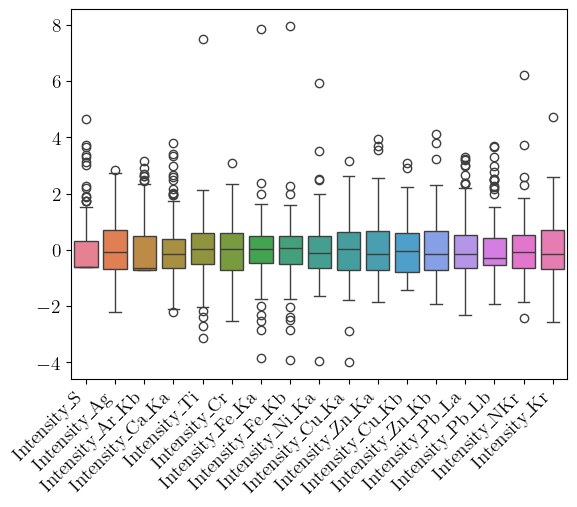

In [28]:
sns.boxplot(X_train_)
plt.xticks(np.arange(X_train_.shape[1]), X_train_.columns, rotation=45, ha='right');

In [29]:
X_train_[(X_train_['Intensity_Cu_Ka'] < 500) | (X_train_['Intensity_Fe_Ka'] > 2500) | (X_train_['Intensity_NKr'] > 1800)]

,Intensity_S,Intensity_Ag,Intensity_Ar_Kb,Intensity_Ca_Ka,Intensity_Ti,Intensity_Cr,Intensity_Fe_Ka,Intensity_Fe_Kb,Intensity_Ni_Ka,Intensity_Cu_Ka,Intensity_Zn_Ka,Intensity_Cu_Kb,Intensity_Zn_Kb,Intensity_Pb_La,Intensity_Pb_Lb,Intensity_NKr,Intensity_Kr
spectrum_name,,,,,,,,,,,,,,,,,
9262,1.477704,0.535352,-0.723844,-0.537889,-0.274394,1.276611,0.188703,0.212638,0.631149,-1.426747,-0.436237,-1.120743,-0.354777,-0.715952,-0.645385,0.576042,-0.031515
8803,3.664615,1.338750,1.743535,-1.120024,0.615097,-1.304448,-0.067158,-0.078516,1.360950,-1.356590,0.657794,-1.427359,0.964912,0.454678,0.622587,1.202523,1.340778
8065,1.876018,-0.642507,-0.723844,0.680333,0.852676,0.481585,1.188601,1.083212,-0.277359,-0.008987,1.485979,-1.034439,1.378555,2.664028,2.274033,-0.661503,-0.403594
8865,1.035682,0.834409,1.434284,0.250794,-0.032913,-0.224625,-0.341773,-0.268449,1.264296,-0.798262,0.134872,-1.231488,0.170643,1.187988,0.926731,1.176291,1.799529
9297,0.304398,-1.354840,-0.723844,-1.058030,-0.525932,0.570473,0.231094,0.264733,-0.081090,-0.658769,-0.444114,-0.338818,-0.339552,0.048856,-0.043796,0.277173,0.265351
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11360,-0.608215,-1.661874,-0.111437,0.250617,-0.324072,0.531417,0.018267,0.031114,-0.464081,0.362033,-0.453933,0.662456,-0.453081,0.006363,0.343424,-0.093648,-0.774567
10525,-0.608215,0.902510,2.483802,0.138319,-0.160192,-1.295381,0.368518,0.392492,-1.134067,-0.004183,-0.183144,0.026387,-0.194754,-0.182920,-0.201609,-0.373884,-0.652871
12684,-0.419068,-0.938478,-0.723844,1.940847,0.821097,0.013368,0.682933,0.613303,-1.593465,2.616087,-0.627137,2.915534,-0.707787,-1.549326,-1.107384,-1.700783,-1.955202


Спектр `12700` имеет явные выбросы на `Fe_Ka` и `Cu_Ka` линиях, применим `clip` как только к этим, так и ко всем линиям, проанализируем результаты

In [30]:
cols = ['Intensity_Fe_Ka', 'Intensity_Cu_Ka']

low_clip_some  = X_train_[cols].quantile(0.05)
high_clip_some = X_train_[cols].quantile(0.95)
X_train_some_clipped       = X_train_.copy()
X_train_some_clipped[cols] = X_train_[cols].clip(lower=low_clip_some, upper=high_clip_some, axis=1)
X_test_some_clipped       = X_test_.copy()
X_test_some_clipped[cols] = X_test_[cols].clip(lower=low_clip_some, upper=high_clip_some, axis=1)


low_clip_all  = X_train_.quantile(0.05)
high_clip_all = X_train_.quantile(0.95)
X_train_all_clipped = X_train_.clip(lower=low_clip_all, upper=high_clip_all, axis=1)
X_test_all_clipped  = X_test_.clip(lower=low_clip_all, upper=high_clip_all, axis=1)

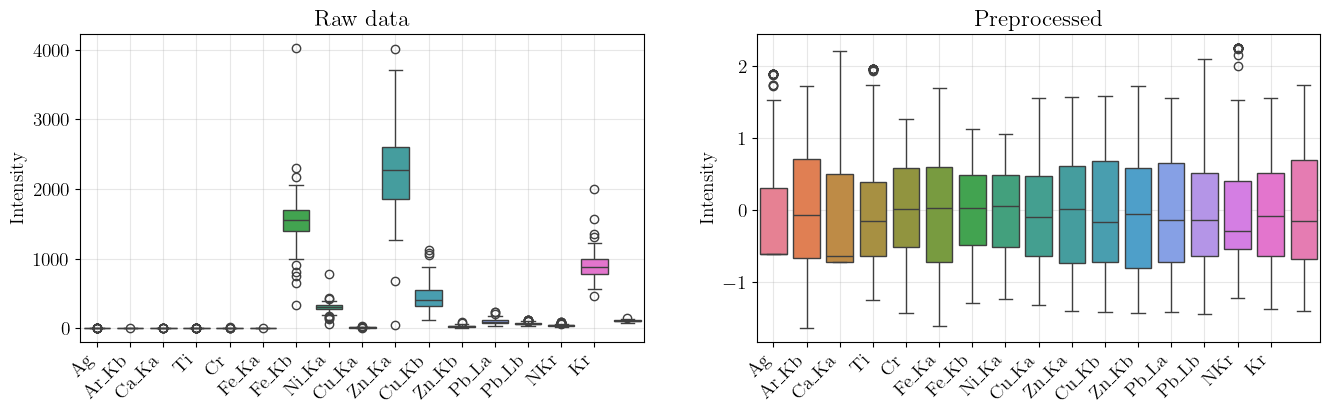

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(16,4))

element_names = [col.replace("Intensity_", "") for col in X_train_.columns[1:]]

axs[0].set_title('Raw data')
sns.boxplot(X_train, ax=axs[0])
axs[0].set_xticks(
    np.arange(X_train_.shape[1] - 1),
    element_names,
    rotation=45,
    ha='right'
)
axs[0].set_ylabel('Intensity')
axs[0].grid(True, alpha=0.3)

axs[1].set_title('Preprocessed')
sns.boxplot(X_train_all_clipped, ax=axs[1])
axs[1].set_xticks(
    np.arange(X_train_.shape[1] - 1),
    element_names,
    rotation=45,
    ha='right'
)
axs[1].set_ylabel('Intensity')
axs[1].grid(True, alpha=0.3)

plt.savefig('clipping.png', bbox_inches="tight", dpi=500)
plt.show()

In [32]:
# Выбор обучающей выборки

# X_train_ = X_train_some_clipped
X_train_ = X_train_all_clipped
X_test_ = X_test_all_clipped

In [33]:
# Добавим смещение

X_train_with_intercept = X_train_.copy()
X_train_with_intercept.insert(loc=0, column='intercept', value=1)
X_train_ = X_train_with_intercept

X_test_with_intercept = X_test_.copy()
X_test_with_intercept.insert(loc=0, column='intercept', value=1)
X_test_ = X_test_with_intercept

In [34]:
X_train_

,intercept,Intensity_S,Intensity_Ag,Intensity_Ar_Kb,Intensity_Ca_Ka,Intensity_Ti,Intensity_Cr,Intensity_Fe_Ka,Intensity_Fe_Kb,Intensity_Ni_Ka,Intensity_Cu_Ka,Intensity_Zn_Ka,Intensity_Cu_Kb,Intensity_Zn_Kb,Intensity_Pb_La,Intensity_Pb_Lb,Intensity_NKr,Intensity_Kr
spectrum_name,,,,,,,,,,,,,,,,,,
9262,1,1.477704,0.535352,-0.723844,-0.537889,-0.274394,1.276611,0.188703,0.212638,0.631149,-1.392026,-0.436237,-1.120743,-0.354777,-0.715952,-0.645385,0.576042,-0.031515
8803,1,1.892996,1.338750,1.743535,-1.120024,0.615097,-1.304448,-0.067158,-0.078516,1.360950,-1.356590,0.657794,-1.427359,0.964912,0.454678,0.622587,1.202523,1.340778
8065,1,1.876018,-0.642507,-0.723844,0.680333,0.852676,0.481585,1.129226,1.053837,-0.277359,-0.008987,1.485979,-1.034439,1.378555,2.100783,2.243897,-0.661503,-0.403594
8865,1,1.035682,0.834409,1.434284,0.250794,-0.032913,-0.224625,-0.341773,-0.268449,1.264296,-0.798262,0.134872,-1.231488,0.170643,1.187988,0.926731,1.176291,1.735797
9297,1,0.304398,-1.354840,-0.723844,-1.058030,-0.525932,0.570473,0.231094,0.264733,-0.081090,-0.658769,-0.444114,-0.338818,-0.339552,0.048856,-0.043796,0.277173,0.265351
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11360,1,-0.608215,-1.635935,-0.111437,0.250617,-0.324072,0.531417,0.018267,0.031114,-0.464081,0.362033,-0.453933,0.662456,-0.453081,0.006363,0.343424,-0.093648,-0.774567
10525,1,-0.608215,0.902510,2.201021,0.138319,-0.160192,-1.295381,0.368518,0.392492,-1.134067,-0.004183,-0.183144,0.026387,-0.194754,-0.182920,-0.201609,-0.373884,-0.652871
12684,1,-0.419068,-0.938478,-0.723844,1.940847,0.821097,0.013368,0.682933,0.613303,-1.320353,1.572393,-0.627137,1.715162,-0.707787,-1.432391,-1.107384,-1.366495,-1.395396


In [35]:
def MSE(y_hat, y):
    return 0.5 * np.mean((y_hat - y)**2)

In [36]:
def soft_threshold(betaHat, tau, penalizeBias=False):
    out = betaHat - np.clip(betaHat, -tau, tau)
    if not penalizeBias:
        out.iloc[0] = betaHat.iloc[0]
    return out

def fit_lasso_proxgrad(X, y, alpha=0.5, maxiter=1000):
    L = np.linalg.norm(X, ord=2) ** 2
    lr = 1.0 / L

    if 'intercept' not in X.columns:
        X.insert(loc=0, column='intercept', value=1)
    w = np.zeros(X.shape[1])

    for _ in range(maxiter):
        grad = X.T @ (X @ w - y)
        w_new = soft_threshold(w - lr * grad, lr * alpha)
        grad_map = (w - w_new) / lr

        if np.linalg.norm(grad_map) < 1e-4:
            print("Hit the norm.")
            break

        w = w_new
    
    return w_new

In [37]:
# def stratified_cv_lasso(X, y, alphas, n_splits=5, maxiter=1000, random_state=None):
#     if random_state == None:
#         random_state = np.random.random()
#         
#     train_ratio = 1.0 - 1.0/n_splits
# 
#     cv_scores = {}
#     for alpha in alphas:
#         errors = []
#         w = None
#         for i in range(n_splits): 
#             
#             train_idx, test_idx = stratified_split(X, y, 'category', train_ratio=train_ratio, random_state=random_state+i)
#              
#             X_train = X.loc[train_idx]
#             X_test  = X.loc[test_idx]
#             y_train = y[train_idx]
#             y_test  = y[test_idx]
#             
#             w = fit_lasso_proxgrad(X_train, y_train, alpha, maxiter)
# 
#             X_test_with_intercept = X_test.copy()
#             if 'intercept' not in X_with_intercept.columns:
#                 X_with_intercept.insert(loc=0, column='intercept', value=1)
#                 
#             y_pred = X_with_intercept @ w
#             
#             mse = np.mean((y_test - y_pred) ** 2)
# 
#             errors.append(mse)
#         
#         cv_scores[alpha] = {'error': np.mean(errors), 'weights': w}
# 
#     best_alpha = min(cv_scores, key=lambda k: cv_scores[k]['error'])
#     best_weights = cv_scores[best_alpha]['weights']
# 
#     return best_alpha, best_weights

In [38]:
w_final_log   = fit_lasso_proxgrad(X_train_.copy(), y_train_log_arr, alpha=0.085, maxiter=1000)
# w_final       = fit_lasso_proxgrad(X_train_.copy(), y_train_arr, alpha=1.2, maxiter=5000)

In [39]:
y_pred_log_arr = X_test_ @ w_final_log
y_pred_no_log_arr = np.array(np.exp(y_pred_log_arr) - epsilon)

# y_pred_arr = np.array(np.maximum(0, X_test_ @ w_final))

In [40]:
rmse_log = np.sqrt(MSE(y_test_arr, y_pred_no_log_arr))
print("RMSE with log   transformation:", rmse_log)

# rmse = np.sqrt(MSE(y_test_arr, y_pred_arr))
# print("RMSE with no    transformation:", rmse)

RMSE with log   transformation: 1.1294896127536431


`MSE with no transformation` демонстрирует лучшие результаты

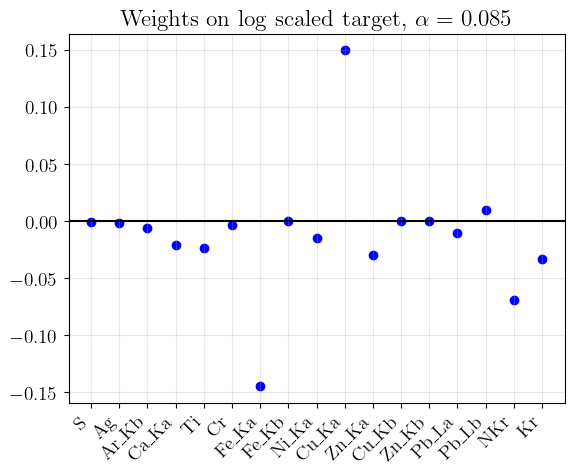

In [41]:
plt.title(r'Weights on log scaled target, $\alpha = 0.085$')
plt.scatter(np.arange(len(w_final_log) - 1), w_final_log[1:], c='b')
element_names = [col.replace("Intensity_", "") for col in X_train_.columns[1:]]
plt.xticks(
    np.arange(X_train_.shape[1] - 1),
    element_names,
    rotation=45,
    ha='right'
)
plt.axhline(0, c='k')

plt.grid(True, alpha=0.3)

plt.savefig('selected_features.png', bbox_inches="tight", dpi=500)
plt.show()

In [42]:
w_final_log

intercept          3.014276
Intensity_S       -0.000942
Intensity_Ag      -0.001768
Intensity_Ar_Kb   -0.006101
Intensity_Ca_Ka   -0.021007
Intensity_Ti      -0.023865
Intensity_Cr      -0.003219
Intensity_Fe_Ka   -0.144774
Intensity_Fe_Kb    0.000000
Intensity_Ni_Ka   -0.014669
Intensity_Cu_Ka    0.149434
Intensity_Zn_Ka   -0.029527
Intensity_Cu_Kb    0.000000
Intensity_Zn_Kb    0.000000
Intensity_Pb_La   -0.010327
Intensity_Pb_Lb    0.009733
Intensity_NKr     -0.069301
Intensity_Kr      -0.033014
dtype: float64

In [43]:
# fig, axs = plt.subplots(1, 2, figsize=(12, 4))
# 
# axs[0].set_title('Weights, log scaled target')
# axs[0].scatter(np.arange(len(w_final_log) - 1), w_final_log[1:], c='b')
# axs[0].set_xticks(np.arange(X_train_.shape[1] - 1), X_train_.columns[1:], rotation=45, ha='right')
# 
# axs[1].set_title('Weights, target with no scale')
# axs[1].scatter(np.arange(len(w_final) - 1), w_final[1:], c='r')
# axs[1].set_xticks(np.arange(X_train_.shape[1] - 1), X_train_.columns[1:], rotation=45, ha='right')
# 
# plt.show()

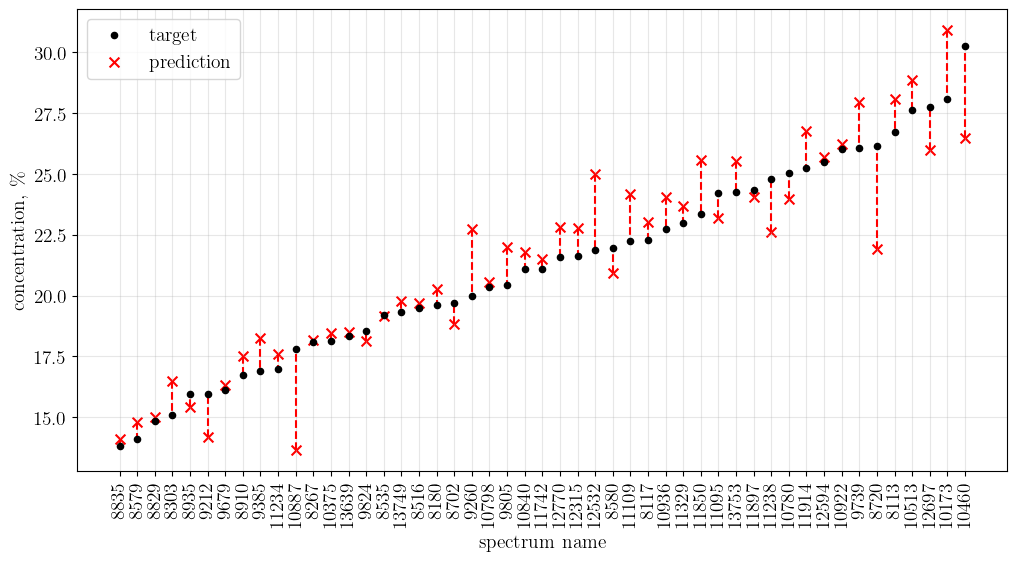

In [44]:
plt.figure(figsize=(12, 6))

plt.scatter(np.arange(y_test_arr.shape[0]), y_test_arr, marker='o', color='k', s=20, zorder=3, label='target')

plt.scatter(np.arange(y_pred_no_log_arr.shape[0]), y_pred_no_log_arr, marker='x', s=50, color='r', label='prediction')
# plt.scatter(np.arange(y_pred_arr.shape[0]),        y_pred_arr,        marker='x', color='b', label='prediction')

plt.xticks(np.arange(X_test.shape[0]), X_test.index, rotation=90)
plt.ylabel('concentration, \%')
plt.xlabel('spectrum name')
plt.grid(True, alpha=0.3)
plt.legend()

for x in range(y_pred_no_log_arr.shape[0]):
    plt.plot([x, x], [y_pred_no_log_arr[x], y_test_arr[x]], c='r', linestyle='--')
# for x in range(y_pred_arr.shape[0]):
#     plt.plot([x, x], [y_pred_arr[x], y_test_arr[x]], c='b', linestyle='--')

plt.savefig('target_prediction.png', bbox_inches="tight", dpi=500)
plt.show()